# **First run Ocean parcels on SSC fieldset**

In [111]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, transforms
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature


from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

%matplotlib inline
from IPython.display import HTML

## Functions

#### Path prefix

In [112]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

#### Useful Kernel

In [113]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

## Load drifters and definitions

In [114]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/jvalenti/MOAD/grid/mesh_mask201702.nc',
    'out': './results',
}

In [115]:
# Duration and timestep [s]
length = 6
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards

In [116]:
N = 5 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 1000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 20.
zvals = dmin + np.random.random_sample([n,N]).T*(dmax-dmin)

## Simulation

In [117]:
start = datetime(2018, 1, 17)
daterange = [start+timedelta(days=i) for i in range(length)]
# Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

/results2/SalishSea/nowcast-green.201905/17jan18/SalishSea_1h_20180117_20180117
/results2/SalishSea/nowcast-green.201905/18jan18/SalishSea_1h_20180118_20180118
/results2/SalishSea/nowcast-green.201905/19jan18/SalishSea_1h_20180119_20180119
/results2/SalishSea/nowcast-green.201905/20jan18/SalishSea_1h_20180120_20180120
/results2/SalishSea/nowcast-green.201905/21jan18/SalishSea_1h_20180121_20180121
/results2/SalishSea/nowcast-green.201905/22jan18/SalishSea_1h_20180122_20180122


### Change name for each run!!

In [118]:
# Set output file name.  Maybe change for each run
fn = f'TEST-long-MP' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

./results/TEST-long-MP20180117_1n_20180123_1n.nc


### Set particle location

In [119]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769], [49.186308,49.975326,49.305448,47.622403,48.399420]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [120]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))
#pset.computeTimeChunk(allow_time_extrapolation=1)
pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-2894/lib4f5a52f564e1a845594740edb49c14b3_0.so
INFO: Temporary output files are stored in ./results/out-UFNJHPGL.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-UFNJHPGL" to convert these to a NetCDF file during the run.
100% (518400.0 of 518400.0) |############| Elapsed Time: 0:04:27 Time:  0:04:27


In [121]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

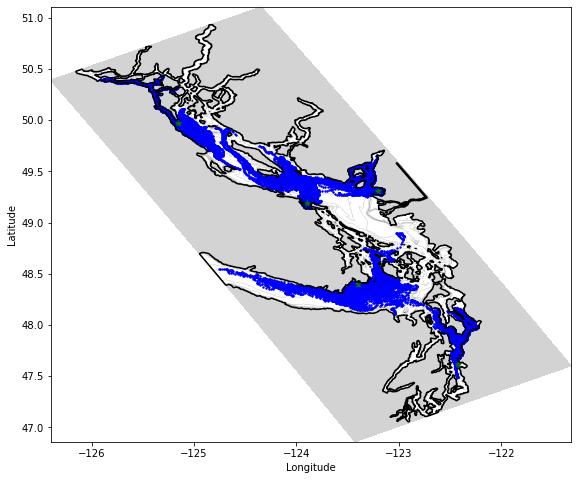

In [122]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/1)
nmin, nmax = 0, -1
for traj in range(n*N):
    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax],c='b',s=2)
ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

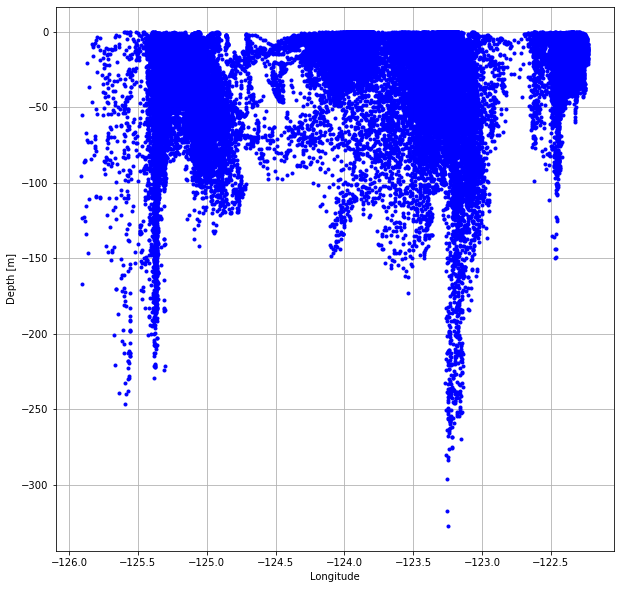

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n*N):
    s = ax.plot(ds.lon[traj, nmin:nmax], -ds.z[traj, nmin:nmax],'.b')
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

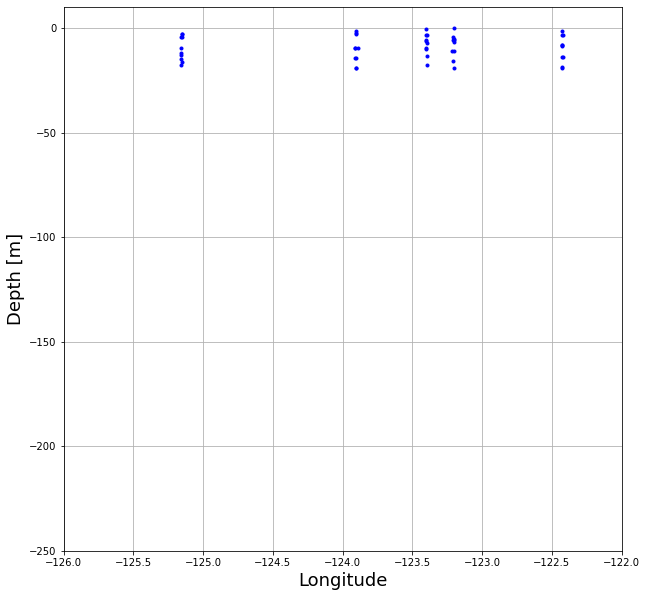

In [106]:
fpd = 1
fig = plt.figure(figsize=(10, 10))

def animate(frames):

    plt.clf()
    ax = fig.add_subplot(111)
    oo = ax.plot(ds.lon[:, frames], -ds.z[:, frames],'.b')
    #ax.grid()
    plt.ylabel('Depth [m]',fontsize=18)
    plt.xlabel('Longitude',fontsize=18)
    plt.ylim([-250,10])
    plt.xlim([-126,-122])
    plt.grid()
    return oo


ani = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fpd))
HTML(ani.to_html5_video())

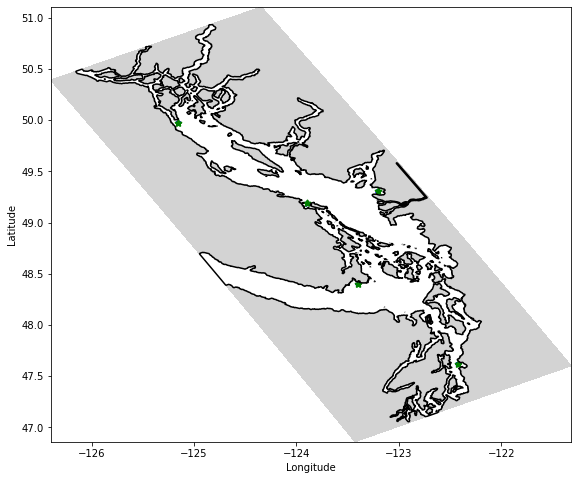

In [125]:
fpd = 1
fig = plt.figure(figsize=(19, 8))
def animate(frames):

    plt.clf()
    ax = fig.add_subplot(111)
    #ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_aspect(1/1)
    ss = ax.scatter(ds.lon[:, frames], ds.lat[:, frames],c='b',s=2)
    #ax.grid()
    ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    #plt.ylim([-250,10])
    #plt.xlim([-126,-122])
    return ss


ani = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fpd))
HTML(ani.to_html5_video())

In [ ]:
# Make map
#fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})
#ax.set_extent([-127, -122, 47, 51])
#ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='lightgray'))
#ax.add_feature(feature.RIVERS, edgecolor='k')
#ax.add_feature(feature.OCEAN)
#gl = ax.gridlines(
#    linestyle=':', color='k', draw_labels=True,
#    xlocs=range(-126, -121), ylocs=range(47, 52),
#)
#gl.top_labels, gl.right_labels = False, False

#ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
#ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
#ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#ax.set_aspect(1/1)
#nmin, nmax = 0, -1
#for traj in range(n*N):
#    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax],c='b',s=2)
#ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
#plt.ylabel('Latitude')
#plt.xlabel('Longitude')
#plt.show()